In [4]:
from QuantLib import *
import numpy as np
from math import *
from pylab import *



[[0.5992 0.5821 0.5925 ... 0.6649 0.6635 0.6519]
 [0.5992 0.6301 0.6088 ... 0.6652 0.6331 0.6191]
 [0.5992 0.6137 0.6296 ... 0.5558 0.551  0.5369]
 ...
 [0.5992 0.5978 0.6155 ... 0.6255 0.634  0.667 ]
 [0.5992 0.6409 0.6569 ... 0.6757 0.6663 0.6721]
 [0.5992 0.6126 0.6103 ... 0.5655 0.5508 0.5523]]
(1000, 21)
bondTmean-Terminal bond
 [0.     0.0113 0.0116 0.0119 0.0098 0.0083 0.009  0.008  0.0073 0.0069
 0.0074 0.0075 0.0072 0.0071 0.0068 0.0069 0.0078 0.0076 0.0078 0.0068
 0.0062]


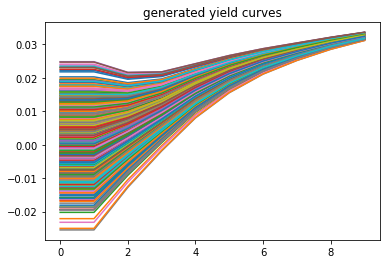

In [91]:
def A(t,T):
    evaldate=Settings.instance().evaluationDate
    forward = crvToday.forwardRate(t, t,Continuous, NoFrequency).rate()
    value = B(t,T)*forward - 0.25*sigma*B(t,T)*sigma*B(t,T)*B(0.0,2.0*t);
    return exp(value)*crvToday.discount(T)/crvToday.discount(t);

def B(t,T):
    return (1.0-exp(-a*(T-t)))/a;

def gamma(t):
        forwardRate =crvToday.forwardRate(t, t, Continuous, NoFrequency).rate()
        temp = sigma*(1.0 - exp(-a*t))/a
        return (forwardRate + 0.5*temp*temp)

def gamma_v(t): #vectorized version of gamma(t)
    res=np.zeros(len(t))
    for i in range(len(t)):
        res[i]=gamma(t[i])
    return res

Nsim=1000
#a=0.03
#sigma=0.00743
#parameters calibrated with Quantlib to coterminal swaptions on 26/dec/2013
a=0.376739
sigma=0.0209835

todaysDate=Date(26,12,2013);
Settings.instance().evaluationDate=todaysDate;
crvTodaydates=[Date(26,12,2013),
               Date(30,6,2014),
               Date(30,7,2014),
               Date(29,8,2014),
               Date(30,9,2014),
               Date(30,10,2014),
               Date(28,11,2014),
               Date(30,12,2014),
               Date(30,1,2015),
               Date(27,2,2015),
               Date(30,3,2015),
               Date(30,4,2015),
               Date(29,5,2015),
               Date(30,6,2015),
               Date(30,12,2015),
               Date(30,12,2016),
               Date(29,12,2017),
               Date(31,12,2018),
               Date(30,12,2019),
               Date(30,12,2020),
               Date(30,12,2021),
               Date(30,12,2022),
               Date(29,12,2023),
               Date(30,12,2024),
               Date(30,12,2025),
               Date(29,12,2028),
               Date(30,12,2033),
               Date(30,12,2038),
               Date(30,12,2043),
               Date(30,12,2048),
               Date(30,12,2053),
               Date(30,12,2058),
               Date(31,12,2063)]
crvTodaydf=[1.0,
            0.998022,
            0.99771,
            0.99739,
            0.997017,
            0.996671,
            0.996337,
            0.995921,
            0.995522,
            0.995157,
            0.994706,
            0.994248,
            0.993805,
            0.993285,
            0.989614,
            0.978541,
            0.961973,
            0.940868,
            0.916831,
            0.890805,
            0.863413,
            0.834987,
            0.807111,
            0.778332,
            0.750525,
            0.674707,
            0.575192,
            0.501258,
            0.44131,
            0.384733,
            0.340425,
            0.294694,
            0.260792
            ]

crvToday=DiscountCurve(crvTodaydates,crvTodaydf,Actual360(),TARGET())
r0= forwardRate =crvToday.forwardRate(0,0, Continuous, NoFrequency).rate()
months=range(3,12*5+1,3)
sPeriods=[str(month)+"m" for month in months]
# print(sPeriods)
Dates=[todaysDate]+[todaysDate + Period(s) for s in sPeriods]
# print(Dates)
T=[0]+[Actual360().yearFraction(todaysDate, Dates[i]) for i in range(1,len(Dates))]
# print(T)
T=np.array(T)
rmean=r0*np.exp(-a*T)+ gamma_v(T) - gamma(0)*np.exp(-a*T)
rvar=sigma*sigma/2.0/a*(1.0-np.exp(-2.0*a*T))
rstd=np.sqrt(rvar)
np.random.seed(1)
stdnorm = np.random.standard_normal(size=(Nsim,len(T)-1))
rmat=np.zeros(shape=(Nsim,len(T)))


for iSim in range(Nsim):
    for iT in range(1,len(T)):
        mean=rmat[iSim,iT-1]*exp(-a*(T[iT]-T[iT-1]))+gamma(T[iT])-gamma(T[iT-1])*exp(-a*(T[iT]-T[iT-1]))
        var=0.5*sigma*sigma/a*(1-exp(-2*a*(T[iT]-T[iT-1])))
        rnew=mean+stdnorm[iSim,iT-1]*sqrt(var)
        #if (rnew<0): rnew=0.001
        rmat[iSim,iT]=rnew
bonds=np.zeros(shape=rmat.shape)

#E(E(exp(rt)|ti) test
for iSim in range(Nsim):
    for iT in range(1,len(T)):
        bonds[iSim,iT]=bonds[iSim,iT-1]+rmat[iSim,iT]*(T[iT]-T[iT-1])

bonds=-bonds;
bonds=np.exp(bonds)

# for i in range(bonds.shape[1]):
#     plot(T,bonds[i])
#     plot(T,[crvToday.discount(T[iT]) for iT in range(len(T))])
# show()

# bondsmean=np.mean(bonds,axis=0)
# plot(T,bondsmean)
# plot(T,[crvToday.discount(T[iT]) for iT in range(len(T))])
# show()


startDate=Date(26,12,2013);

crvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]
npvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]

for row in crvMat:
    row[0]=crvToday


for iT in range(1,len(T)):
    for iSim in range(Nsim):
        crvDate=Dates[iT];
        crvDates=[crvDate]+[crvDate+Period(k,Years) for k in range(1,21)]
        rt=rmat[iSim,iT]
        #if (rt<0): rt=0
        crvDiscounts=[1.0]+[A(T[iT],T[iT]+k)*exp(-B(T[iT],T[iT]+k)*rt) for k in range(1,21)]
        crvMat[iSim][iT]=DiscountCurve(crvDates,crvDiscounts,Actual360(),TARGET())

bondT=np.zeros(shape=rmat.shape)
for iSim in range(Nsim):
    for iT in range(len(T)):
        bondT[iSim,iT]=bonds[iSim,iT]*crvMat[iSim][iT].discount(19-T[iT])

print(bondT)
print(bondT.shape)

bondTmean=np.mean(bondT,axis=0)
np.set_printoptions(precision=4,suppress=True)
print('bondTmean-Terminal bond\n',bondTmean-crvToday.discount(19))


plot(range(10),[crvMat[0][0].forwardRate(k, k,Continuous, NoFrequency).rate() for k in range(10)])
for i in range(max(Nsim,10)):
    plot(range(10),[crvMat[i][1].forwardRate(k, k,Continuous, NoFrequency).rate() for k in range(10)])
title('generated yield curves')
show()


In [92]:
#indexes definitions
forecastTermStructure = RelinkableYieldTermStructureHandle()
index = Euribor(Period("6m"),forecastTermStructure)

#swap 1 definition
maturity = Date(26,12,2018);
fixedSchedule = Schedule(startDate, maturity,Period("6m"), TARGET(),ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
floatingSchedule = Schedule(startDate, maturity,Period("6m"),TARGET() ,ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
swap1 = VanillaSwap(VanillaSwap.Receiver, 10000000,fixedSchedule,0.02, Actual360(),floatingSchedule, index, 0,Actual360())  #0.01215



In [94]:
for iT in range(len(T)):
    Settings.instance().evaluationDate=Dates[iT]
    allDates= list(floatingSchedule)
    fixingdates=[index.fixingDate(floatingSchedule[iDate]) for iDate in range(len(allDates)) if index.fixingDate(floatingSchedule[iDate])<=Dates[iT]]
    if fixingdates:
        for date in fixingdates[:-1]:
            try:index.addFixing(date,0.0)
            except:pass
        try:index.addFixing(fixingdates[-1],rmean[iT])
        except:pass
    discountTermStructure = RelinkableYieldTermStructureHandle()
    swapEngine = DiscountingSwapEngine(discountTermStructure)
    swap1.setPricingEngine(swapEngine)

    for iSim in range(Nsim):
        crv=crvMat[iSim][iT]
        discountTermStructure.linkTo(crv)
        forecastTermStructure.linkTo(crv)
        npvMat[iSim][iT]=swap1.NPV()

[Date(23,12,2013)]


RuntimeError: 2nd leg: negative time (-4.56667) given

In [88]:
npv= npvMat[0,0]
#replace negative values with 0
npvMat[npvMat<0]=0
EE=np.mean(npvMat,axis=0)
print ('\nEE:\n',EE)
#print '\nrmat:\n',rmat
print ('\nrmean:\n',rmean)
#print '\nrstd:\n',rstd
#print '\n95% are in \n',zip(rmean-2*rstd,rmean+2*rstd)


S=0.05
R=0.4
sum=0
for i in range(len(T)-1):
    sum=sum+0.5*crvToday.discount(T[i+1])*(EE[i]+EE[i+1])*(exp(-S*T[i]/(1.0-R))-exp(-S*T[i+1]/(1.0-R)))
CVA=(1.0-R)*sum
print ("\nnpv=",npv)
print ("\nCVA=",CVA)


plot(T,EE)
title('Expected Exposure')
xlabel('Time in years')
#plot(T,np.mean(rmat,axis=0))
#plot(T,rmean)
#plot(T,[npvMat[0,0]]*len(T))
show()
print('\nnpv',npvMat)

TypeError: list indices must be integers or slices, not tuple

In [3]:
!pip install QuantLib


     |████████████████████████████████| 20.6 MB 1.7 MB/s eta 0:00:01


# one slot

['3m', '6m', '9m', '12m', '15m', '18m', '21m', '24m', '27m', '30m', '33m', '36m', '39m', '42m', '45m', '48m', '51m', '54m', '57m', '60m']
bondTmean-Terminal bond
 [0.     0.0051 0.0055 0.0058 0.0037 0.0022 0.003  0.002  0.0013 0.0009
 0.0015 0.0015 0.0013 0.0011 0.0009 0.001  0.0018 0.0017 0.0019 0.0009
 0.0004]


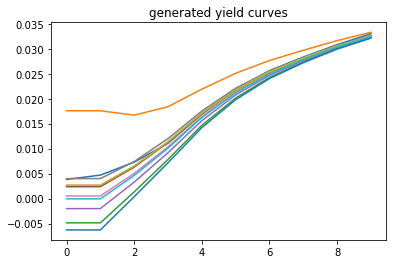


EE:
 [401670.1158 413417.5971 340503.4441 355666.4159 342149.0633 267313.078
 215153.3631 221452.3042 216409.8956 177115.4065 166577.0528 140449.3265
 128879.6743 110513.4705  60856.0809  64392.8642  44695.2762  36873.2193
      0.          0.          0.    ]

rmean:
 [0.0038 0.0038 0.0039 0.0043 0.0049 0.0055 0.0062 0.0077 0.0077 0.0116
 0.0117 0.0117 0.0118 0.0177 0.0177 0.0178 0.0178 0.0228 0.0228 0.0228
 0.0229]

npv= 401670.1157927497

CVA= 39034.442465293185


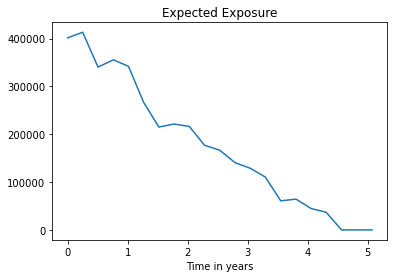


npv [[401670.1158  89032.1399 177863.9439 ...      0.          0.
       0.    ]
 [401670.1158 634806.5235 298637.7966 ...      0.          0.
       0.    ]
 [401670.1158 448834.6279 515442.0762 ...      0.          0.
       0.    ]
 ...
 [401670.1158 267727.0817 391613.2219 ...      0.          0.
       0.    ]
 [401670.1158 756877.1519 758378.6869 ...      0.          0.
       0.    ]
 [401670.1158 436911.6699 327666.0919 ...      0.          0.
       0.    ]]


In [95]:
from QuantLib import *
import numpy as np
from math import *
from pylab import *

def A(t,T):
    evaldate=Settings.instance().evaluationDate
    forward = crvToday.forwardRate(t, t,Continuous, NoFrequency).rate()
    value = B(t,T)*forward - 0.25*sigma*B(t,T)*sigma*B(t,T)*B(0.0,2.0*t);
    return exp(value)*crvToday.discount(T)/crvToday.discount(t);

def B(t,T):
    return (1.0-exp(-a*(T-t)))/a;

def gamma(t):
        forwardRate =crvToday.forwardRate(t, t, Continuous, NoFrequency).rate()
        temp = sigma*(1.0 - exp(-a*t))/a
        return (forwardRate + 0.5*temp*temp)

def gamma_v(t): #vectorized version of gamma(t)
    res=np.zeros(len(t))
    for i in range(len(t)):
        res[i]=gamma(t[i])
    return res

Nsim=1000
#a=0.03
#sigma=0.00743
#parameters calibrated with Quantlib to coterminal swaptions on 26/dec/2013
a=0.376739
sigma=0.0209835

todaysDate=Date(26,12,2013);
Settings.instance().evaluationDate=todaysDate;
crvTodaydates=[Date(26,12,2013),
               Date(30,6,2014),
               Date(30,7,2014),
               Date(29,8,2014),
               Date(30,9,2014),
               Date(30,10,2014),
               Date(28,11,2014),
               Date(30,12,2014),
               Date(30,1,2015),
               Date(27,2,2015),
               Date(30,3,2015),
               Date(30,4,2015),
               Date(29,5,2015),
               Date(30,6,2015),
               Date(30,12,2015),
               Date(30,12,2016),
               Date(29,12,2017),
               Date(31,12,2018),
               Date(30,12,2019),
               Date(30,12,2020),
               Date(30,12,2021),
               Date(30,12,2022),
               Date(29,12,2023),
               Date(30,12,2024),
               Date(30,12,2025),
               Date(29,12,2028),
               Date(30,12,2033),
               Date(30,12,2038),
               Date(30,12,2043),
               Date(30,12,2048),
               Date(30,12,2053),
               Date(30,12,2058),
               Date(31,12,2063)]
crvTodaydf=[1.0,
            0.998022,
            0.99771,
            0.99739,
            0.997017,
            0.996671,
            0.996337,
            0.995921,
            0.995522,
            0.995157,
            0.994706,
            0.994248,
            0.993805,
            0.993285,
            0.989614,
            0.978541,
            0.961973,
            0.940868,
            0.916831,
            0.890805,
            0.863413,
            0.834987,
            0.807111,
            0.778332,
            0.750525,
            0.674707,
            0.575192,
            0.501258,
            0.44131,
            0.384733,
            0.340425,
            0.294694,
            0.260792
            ]

crvToday=DiscountCurve(crvTodaydates,crvTodaydf,Actual360(),TARGET())
#crvToday=FlatForward(todaysDate,0.0121,Actual360())

r0=forwardRate =crvToday.forwardRate(0,0, Continuous, NoFrequency).rate()
months=range(3,12*5+1,3)
sPeriods=[str(month)+"m" for month in months]
print (sPeriods)
Dates=[todaysDate]+[todaysDate+Period(s) for s in sPeriods]
T=[0]+[Actual360().yearFraction(todaysDate,Dates[i]) for i in range(1,len(Dates))]
T=np.array(T)
rmean=r0*np.exp(-a*T)+ gamma_v(T) -gamma(0)*np.exp(-a*T)
rvar=sigma*sigma/2.0/a*(1.0-np.exp(-2.0*a*T))
rstd=np.sqrt(rvar)
np.random.seed(1)
stdnorm = np.random.standard_normal(size=(Nsim,len(T)-1))

rmat=np.zeros(shape=(Nsim,len(T)))
rmat[:,0]=r0
for iSim in range(Nsim):
    for iT in range(1,len(T)):
        mean=rmat[iSim,iT-1]*exp(-a*(T[iT]-T[iT-1]))+gamma(T[iT])-gamma(T[iT-1])*exp(-a*(T[iT]-T[iT-1]))
        var=0.5*sigma*sigma/a*(1-exp(-2*a*(T[iT]-T[iT-1])))
        rnew=mean+stdnorm[iSim,iT-1]*sqrt(var)
        #if (rnew<0): rnew=0.001
        rmat[iSim,iT]=rnew

bonds=np.zeros(shape=rmat.shape)

#E(E(exp(rt)|ti) test
for iSim in range(Nsim):
    for iT in range(1,len(T)):
        bonds[iSim,iT]=bonds[iSim,iT-1]+rmat[iSim,iT]*(T[iT]-T[iT-1])

bonds=-bonds;
bonds=np.exp(bonds)

bondsmean=np.mean(bonds,axis=0)
#plot(T,bondsmean)
#plot(T,[crvToday.discount(T[iT]) for iT in range(len(T))])
#show()

startDate=Date(26,12,2013);

crvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]
npvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]

for row in crvMat:
    row[0]=crvToday

for iT in range(1,len(T)):
    for iSim in range(Nsim):
        crvDate=Dates[iT];
        crvDates=[crvDate]+[crvDate+Period(k,Years) for k in range(1,21)]
        rt=rmat[iSim,iT]
        #if (rt<0): rt=0
        crvDiscounts=[1.0]+[A(T[iT],T[iT]+k)*exp(-B(T[iT],T[iT]+k)*rt) for k in range(1,21)]
        crvMat[iSim][iT]=DiscountCurve(crvDates,crvDiscounts,Actual360(),TARGET())

bondT=np.zeros(shape=rmat.shape)
for iSim in range(Nsim):
    for iT in range(len(T)):
        bondT[iSim,iT]=bonds[iSim,iT]*crvMat[iSim][iT].discount(19-T[iT])

bondTmean=np.mean(bondT,axis=0)
np.set_printoptions(precision=4,suppress=True)
print('bondTmean-Terminal bond\n',bondTmean-crvToday.discount(19))


plot(range(10),[crvMat[0][0].forwardRate(k, k,Continuous, NoFrequency).rate() for k in range(10)])
for i in range(min(Nsim,10)):
    plot(range(10),[crvMat[i][1].forwardRate(k, k,Continuous, NoFrequency).rate() for k in range(10)])
title('generated yield curves')
show()

#indexes definitions
forecastTermStructure = RelinkableYieldTermStructureHandle()
index = Euribor(Period("6m"),forecastTermStructure)

#swap 1 definition
maturity = Date(26,12,2018);
fixedSchedule = Schedule(startDate, maturity,Period("6m"), TARGET(),ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
floatingSchedule = Schedule(startDate, maturity,Period("6m"),TARGET() ,ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
swap1 = VanillaSwap(VanillaSwap.Receiver, 10000000,fixedSchedule,0.02, Actual360(),floatingSchedule, index, 0,Actual360())  #0.01215

for iT in range(len(T)):
    Settings.instance().evaluationDate=Dates[iT]
    allDates= list(floatingSchedule)
    fixingdates=[index.fixingDate(floatingSchedule[iDate]) for iDate in range(len(allDates)) if index.fixingDate(floatingSchedule[iDate])<=Dates[iT]]
    if fixingdates:
        for date in fixingdates[:-1]:
            try:index.addFixing(date,0.0)
            except:pass
        try:index.addFixing(fixingdates[-1],rmean[iT])
        except:pass
    discountTermStructure = RelinkableYieldTermStructureHandle()
    swapEngine = DiscountingSwapEngine(discountTermStructure)
    swap1.setPricingEngine(swapEngine)

    for iSim in range(Nsim):
        crv=crvMat[iSim][iT]
        discountTermStructure.linkTo(crv)
        forecastTermStructure.linkTo(crv)
        npvMat[iSim][iT]=swap1.NPV()

npvMat=np.array(npvMat)
npv=npvMat[0,0]
#replace negative values with 0
npvMat[npvMat<0]=0



# EE=np.mean(npvMat,axis=0)
# print ('\nEE:\n',EE)
# #print '\nrmat:\n',rmat
# print( '\nrmean:\n',rmean)
# #print '\nrstd:\n',rstd
# #print '\n95% are in \n',zip(rmean-2*rstd,rmean+2*rstd)


# S=0.05
# R=0.4
# sum=0
# for i in range(len(T)-1):
#     sum=sum+0.5*crvToday.discount(T[i+1])*(EE[i]+EE[i+1])*(exp(-S*T[i]/(1.0-R))-exp(-S*T[i+1]/(1.0-R)))
# CVA=(1.0-R)*sum
# print( "\nnpv=",npv)
# print ("\nCVA=",CVA)


# plot(T,EE)
# title('Expected Exposure')
# xlabel('Time in years')
# #plot(T,np.mean(rmat,axis=0))
# #plot(T,rmean)
# #plot(T,[npvMat[0,0]]*len(T))
# show()
# print ("\nnpv",npvMat)

In [96]:
npvMat

S=0.05
R=0.4
sum=0
for i in range(len(T)-1):
    sum=sum+0.5*crvToday.discount(T[i+1])*(EE[i]+EE[i+1])*(exp(-S*T[i]/(1.0-R))-exp(-S*T[i+1]/(1.0-R)))
CVA=(1.0-R)*sum
print( "\nnpv=",npv)
print ("\nCVA=",CVA)


plot(T,EE)

array([[401670.1158,  89032.1399, 177863.9439, ...,      0.    ,
             0.    ,      0.    ],
       [401670.1158, 634806.5235, 298637.7966, ...,      0.    ,
             0.    ,      0.    ],
       [401670.1158, 448834.6279, 515442.0762, ...,      0.    ,
             0.    ,      0.    ],
       ...,
       [401670.1158, 267727.0817, 391613.2219, ...,      0.    ,
             0.    ,      0.    ],
       [401670.1158, 756877.1519, 758378.6869, ...,      0.    ,
             0.    ,      0.    ],
       [401670.1158, 436911.6699, 327666.0919, ...,      0.    ,
             0.    ,      0.    ]])

In [ ]:
# from QuantLib import *
# import numpy as np
# from math import *
# from pylab import *

# def A(t,T):
#     evaldate=Settings.instance().evaluationDate
#     forward = crvToday.forwardRate(t, t,Continuous, NoFrequency).rate()
#     value = B(t,T)*forward - 0.25*sigma*B(t,T)*sigma*B(t,T)*B(0.0,2.0*t);
#     return exp(value)*crvToday.discount(T)/crvToday.discount(t);

# def B(t,T):
#     return (1.0-exp(-a*(T-t)))/a;

# def gamma(t):
#         forwardRate =crvToday.forwardRate(t, t, Continuous, NoFrequency).rate()
#         temp = sigma*(1.0 - exp(-a*t))/a
#         return (forwardRate + 0.5*temp*temp)

# def gamma_v(t): #vectorized version of gamma(t)
#     res=np.zeros(len(t))
#     for i in range(len(t)):
#         res[i]=gamma(t[i])
#     return res

# Nsim=1000
# #a=0.03
# #sigma=0.00743
# #parameters calibrated with Quantlib to coterminal swaptions on 26/dec/2013
# a=0.376739
# sigma=0.0209835

# todaysDate=Date(26,12,2013);
# Settings.instance().evaluationDate=todaysDate;
# crvTodaydates=[Date(26,12,2013),
#                Date(30,6,2014),
#                Date(30,7,2014),
#                Date(29,8,2014),
#                Date(30,9,2014),
#                Date(30,10,2014),
#                Date(28,11,2014),
#                Date(30,12,2014),
#                Date(30,1,2015),
#                Date(27,2,2015),
#                Date(30,3,2015),
#                Date(30,4,2015),
#                Date(29,5,2015),
#                Date(30,6,2015),
#                Date(30,12,2015),
#                Date(30,12,2016),
#                Date(29,12,2017),
#                Date(31,12,2018),
#                Date(30,12,2019),
#                Date(30,12,2020),
#                Date(30,12,2021),
#                Date(30,12,2022),
#                Date(29,12,2023),
#                Date(30,12,2024),
#                Date(30,12,2025),
#                Date(29,12,2028),
#                Date(30,12,2033),
#                Date(30,12,2038),
#                Date(30,12,2043),
#                Date(30,12,2048),
#                Date(30,12,2053),
#                Date(30,12,2058),
#                Date(31,12,2063)]
# crvTodaydf=[1.0,
#             0.998022,
#             0.99771,
#             0.99739,
#             0.997017,
#             0.996671,
#             0.996337,
#             0.995921,
#             0.995522,
#             0.995157,
#             0.994706,
#             0.994248,
#             0.993805,
#             0.993285,
#             0.989614,
#             0.978541,
#             0.961973,
#             0.940868,
#             0.916831,
#             0.890805,
#             0.863413,
#             0.834987,
#             0.807111,
#             0.778332,
#             0.750525,
#             0.674707,
#             0.575192,
#             0.501258,
#             0.44131,
#             0.384733,
#             0.340425,
#             0.294694,
#             0.260792
#             ]

# crvToday=DiscountCurve(crvTodaydates,crvTodaydf,Actual360(),TARGET())
# #crvToday=FlatForward(todaysDate,0.0121,Actual360())

# r0=forwardRate =crvToday.forwardRate(0,0, Continuous, NoFrequency).rate()
# months=range(3,12*5+1,3)
# sPeriods=[str(month)+"m" for month in months]
# print (sPeriods)
# Dates=[todaysDate]+[todaysDate+Period(s) for s in sPeriods]
# T=[0]+[Actual360().yearFraction(todaysDate,Dates[i]) for i in range(1,len(Dates))]
# T=np.array(T)
# rmean=r0*np.exp(-a*T)+ gamma_v(T) -gamma(0)*np.exp(-a*T)
# rvar=sigma*sigma/2.0/a*(1.0-np.exp(-2.0*a*T))
# rstd=np.sqrt(rvar)
# np.random.seed(1)
# stdnorm = np.random.standard_normal(size=(Nsim,len(T)-1))

# rmat=np.zeros(shape=(Nsim,len(T)))
# rmat[:,0]=r0
# for iSim in range(Nsim):
#     for iT in range(1,len(T)):
#         mean=rmat[iSim,iT-1]*exp(-a*(T[iT]-T[iT-1]))+gamma(T[iT])-gamma(T[iT-1])*exp(-a*(T[iT]-T[iT-1]))
#         var=0.5*sigma*sigma/a*(1-exp(-2*a*(T[iT]-T[iT-1])))
#         rnew=mean+stdnorm[iSim,iT-1]*sqrt(var)
#         #if (rnew<0): rnew=0.001
#         rmat[iSim,iT]=rnew

# bonds=np.zeros(shape=rmat.shape)

# #E(E(exp(rt)|ti) test
# for iSim in range(Nsim):
#     for iT in range(1,len(T)):
#         bonds[iSim,iT]=bonds[iSim,iT-1]+rmat[iSim,iT]*(T[iT]-T[iT-1])

# bonds=-bonds;
# bonds=np.exp(bonds)

# bondsmean=np.mean(bonds,axis=0)
# #plot(T,bondsmean)
# #plot(T,[crvToday.discount(T[iT]) for iT in range(len(T))])
# #show()

# startDate=Date(26,12,2013);

# crvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]
# npvMat= [ [ 0 for i in range(len(T)) ] for iSim in range(Nsim) ]

# for row in crvMat:
#     row[0]=crvToday

# for iT in range(1,len(T)):
#     for iSim in range(Nsim):
#         crvDate=Dates[iT];
#         crvDates=[crvDate]+[crvDate+Period(k,Years) for k in range(1,21)]
#         rt=rmat[iSim,iT]
#         #if (rt<0): rt=0
#         crvDiscounts=[1.0]+[A(T[iT],T[iT]+k)*exp(-B(T[iT],T[iT]+k)*rt) for k in range(1,21)]
#         crvMat[iSim][iT]=DiscountCurve(crvDates,crvDiscounts,Actual360(),TARGET())

# bondT=np.zeros(shape=rmat.shape)
# for iSim in range(Nsim):
#     for iT in range(len(T)):
#         bondT[iSim,iT]=bonds[iSim,iT]*crvMat[iSim][iT].discount(19-T[iT])

# bondTmean=np.mean(bondT,axis=0)
# np.set_printoptions(precision=4,suppress=True)
# print('bondTmean-Terminal bond\n',bondTmean-crvToday.discount(19))


# plot(range(10),[crvMat[0][0].forwardRate(k, k,Continuous, NoFrequency).rate() for k in range(10)])
# for i in range(min(Nsim,10)):
#     plot(range(10),[crvMat[i][1].forwardRate(k, k,Continuous, NoFrequency).rate() for k in range(10)])
# title('generated yield curves')
# show()

# #indexes definitions
# forecastTermStructure = RelinkableYieldTermStructureHandle()
# index = Euribor(Period("6m"),forecastTermStructure)

# #swap 1 definition
# maturity = Date(26,12,2018);
# fixedSchedule = Schedule(startDate, maturity,Period("6m"), TARGET(),ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
# floatingSchedule = Schedule(startDate, maturity,Period("6m"),TARGET() ,ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
# swap1 = VanillaSwap(VanillaSwap.Receiver, 10000000,fixedSchedule,0.02, Actual360(),floatingSchedule, index, 0,Actual360())  #0.01215

# for iT in range(len(T)):
#     Settings.instance().evaluationDate=Dates[iT]
#     allDates= list(floatingSchedule)
#     fixingdates=[index.fixingDate(floatingSchedule[iDate]) for iDate in range(len(allDates)) if index.fixingDate(floatingSchedule[iDate])<=Dates[iT]]
#     if fixingdates:
#         for date in fixingdates[:-1]:
#             try:index.addFixing(date,0.0)
#             except:pass
#         try:index.addFixing(fixingdates[-1],rmean[iT])
#         except:pass
#     discountTermStructure = RelinkableYieldTermStructureHandle()
#     swapEngine = DiscountingSwapEngine(discountTermStructure)
#     swap1.setPricingEngine(swapEngine)

#     for iSim in range(Nsim):
#         crv=crvMat[iSim][iT]
#         discountTermStructure.linkTo(crv)
#         forecastTermStructure.linkTo(crv)
#         npvMat[iSim][iT]=swap1.NPV()

# npvMat=np.array(npvMat)
# npv=npvMat[0,0]
# #replace negative values with 0
# npvMat[npvMat<0]=0
# EE=np.mean(npvMat,axis=0)
# print ('\nEE:\n',EE)
# #print '\nrmat:\n',rmat
# print( '\nrmean:\n',rmean)
# #print '\nrstd:\n',rstd
# #print '\n95% are in \n',zip(rmean-2*rstd,rmean+2*rstd)


# S=0.05
# R=0.4
# sum=0
# for i in range(len(T)-1):
#     sum=sum+0.5*crvToday.discount(T[i+1])*(EE[i]+EE[i+1])*(exp(-S*T[i]/(1.0-R))-exp(-S*T[i+1]/(1.0-R)))
# CVA=(1.0-R)*sum
# print( "\nnpv=",npv)
# print ("\nCVA=",CVA)


# plot(T,EE)
# title('Expected Exposure')
# xlabel('Time in years')
# #plot(T,np.mean(rmat,axis=0))
# #plot(T,rmean)
# #plot(T,[npvMat[0,0]]*len(T))
# show()
# print ("\nnpv",npvMat)